In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tensorflow.keras.callbacks import Callback
import os
import numpy

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Model 4/ZNStaining"

In [ ]:
def count_images_per_label(dataset_path):
    labels = os.listdir(dataset_path)
    counts = {}
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        counts[label] = len(os.listdir(label_path))
    return counts

In [ ]:
counts = count_images_per_label(dataset_path)
print("Jumlah gambar sebelum augmentasi:", counts)

Jumlah gambar sebelum augmentasi: {'OverStaining': 18, 'LessStaining': 40, 'GoodStaining': 76}


In [ ]:
target_count = 100

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [ ]:
def augment_images(label_path, target_count):
    images = os.listdir(label_path)
    current_count = len(images)

    if current_count >= target_count:
        for img_path in images[target_count:]:
            img_path = os.path.join(label_path, img_name)
            os.remove(img_path)
        return

    needed_count = target_count - current_count
    for img_name in images[:needed_count]:
      img_path = os.path.join(label_path, img_name)
      img = image.load_img(img_path)
      x = image.img_to_array(img)
      x = x.reshape((1,) + x.shape)
      i = 0

      for batch in datagen.flow(x, batch_size=1, save_to_dir=label_path, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= 1:
            break


In [ ]:
labels = os.listdir(dataset_path)
for label in labels:
    label_path = os.path.join(dataset_path, label)
    augment_images(label_path, target_count)

counts = count_images_per_label(dataset_path)
print("Jumlah gambar setelah diaugmentasi: ", counts)

Jumlah gambar setelah diaugmentasi:  {'OverStaining': 72, 'LessStaining': 100, 'GoodStaining': 100}


In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [ ]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

Found 218 images belonging to 3 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 54 images belonging to 3 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class customEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy')>0.95 and logs.get('val_accuracy') > 0.95:
            print("\nAkurasi telah mencapai >95%!")
            self.model.stop_training = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
custom_early_stopping = customEarlyStopping()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 50,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.8082 - loss: 0.4238 - val_accuracy: 0.8750 - val_loss: 0.2528
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8438 - loss: 0.3048

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 636ms/step - accuracy: 0.8438 - loss: 0.3048 - val_accuracy: 0.9375 - val_loss: 0.2518
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.8396 - loss: 0.3758 - val_accuracy: 0.9375 - val_loss: 0.0824
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7812 - loss: 0.5027 - val_accuracy: 0.8750 - val_loss: 0.2229
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8171 - loss: 0.8868 - val_accuracy: 0.9062 - val_loss: 0.6472
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.8125 - loss: 0.3393 - val_accuracy: 0.8750 - val_loss: 0.2739
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8080 - loss: 0.4393 - val_accuracy: 0.9375 - val_loss: 0.1259
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 787ms/step - accuracy: 0.9375 - loss: 0.2027 - val_accuracy: 0.8750 - val_loss: 0.2521
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.8462 - loss: 0.3331 - val_accuracy: 0.8750 - val_loss: 0.2510
Epoch 10/50
6

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9545 - loss: 0.1116
Loss: 0.10703147202730179
Accuracy: 0.9629629850387573


In [ ]:
model.save('/content/drive/MyDrive/Hasil Model/model4.h5')

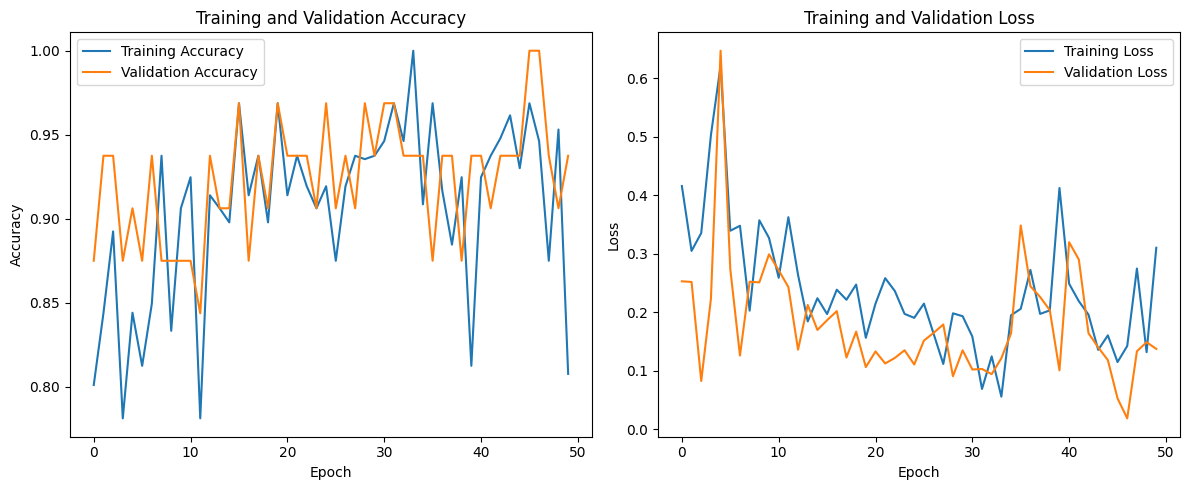

In [ ]:
# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 5))

# Grafik Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()